In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn 
import torch.optim as optim

import copy
import tqdm

import util
import os 

In [2]:
cwd = os.getcwd()
print(cwd)

/home/linhnm/msc_code/big_data_mining/eabdt/python


In [3]:
dataset = 'mix'

training_batch_from = 0
training_batch_to = 3000
val_batch_from = 3000
val_batch_to = 3600

testing_batch_from = 0
testing_batch_to = 400

# training_batch_from = 0
# training_batch_to = 40
# val_batch_from = 40
# val_batch_to = 50

# testing_batch_from = 0
# testing_batch_to = 8

In [4]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda:0'
  print('ok')

ok


In [5]:
X_train = util.load_vector(os.path.join(cwd, '../data/vectorize/384/mix/training_set'), training_batch_from, training_batch_to)
y_train = util.load_label(os.path.join(cwd, '../data/raw/mix/training_set'), training_batch_from, training_batch_to)

X_val = util.load_vector(os.path.join(cwd, '../data/vectorize/384/mix/training_set'), val_batch_from, val_batch_to)
y_val = util.load_label(os.path.join(cwd, '../data/raw/mix/training_set'), val_batch_from, val_batch_to)

X_test = util.load_vector(os.path.join(cwd, '../data/vectorize/384/mix/testing_set'), testing_batch_from, testing_batch_to)
y_test = util.load_label(os.path.join(cwd, '../data/raw/mix/testing_set'), testing_batch_from, testing_batch_to)

In [6]:
X_train.shape

(3000000, 384)

In [7]:
epochs = 200
trigger = 1
early_stopping_round = 20

input_dim = 384
# input_dim = 768
output_dim = 1
learning_rate = 0.1

In [8]:
class SimpleSoftmax(nn.Module):
  # Constructor
  def __init__(self, input_size, hidden_neurons, output_size):
    super(SimpleSoftmax, self).__init__()
    # hidden layer 
    self.linear_one = torch.nn.Linear(input_size, hidden_neurons, bias=True)
    self.linear_two = torch.nn.Linear(hidden_neurons, output_size, bias=True) 
    # defining layers as attributes
    self.layer_in = None
    self.act = None
    self.layer_out = None
  # prediction function
  def forward(self, x):
    self.layer_in = self.linear_one(x)
    self.act = torch.sigmoid(self.layer_in)
    self.layer_out = self.linear_two(self.act)
    y_pred = torch.sigmoid(self.linear_two(self.act))
    return y_pred

In [9]:
model = SimpleSoftmax(input_dim, 64, output_dim)
model.to(device)

SimpleSoftmax(
  (linear_one): Linear(in_features=384, out_features=64, bias=True)
  (linear_two): Linear(in_features=64, out_features=1, bias=True)
)

In [10]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
# X_gpu_train = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_gpu_train = torch.flatten(torch.tensor(y_train).type(torch.float32)).to(device)
X_gpu_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_gpu_val = torch.flatten(torch.tensor(y_val).type(torch.float32)).to(device)
X_gpu_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_gpu_test = torch.flatten(torch.tensor(y_test).type(torch.float32)).to(device)

In [12]:
import time
tol_acc = 2
warming = 20
losses = []
losses_val = []
acc_train = []
acc_val = []
Iterations = []
best_loss = torch.tensor(np.inf).to(device)
best_acc = 0
best_weights = None
iter = 0
early = 0
start = time.time()
mini_batch_size = 1024
num_mini_batch = int(X_train.shape[0] / mini_batch_size)
# X_gpu_train_shuffle = X_gpu_train
for epoch in tqdm.tqdm(range(int(epochs)),desc='Training Epochs'):
    
    for bid in range(num_mini_batch):
        idx = np.random.randint(X_train.shape[0], size=mini_batch_size)
        X_train_batch = X_train[idx, :]
        x = torch.tensor(X_train_batch, dtype=torch.float32).to(device)
        # indices = torch.randperm(X_gpu_train.shape[0])[:mini_batch_size]
        # x = X_gpu_train[indices]
    
        # start = time.time()
        # x = X_gpu_train
        # labels = y_gpu_train[indices]
        y_train_batch = y_train[idx]
        labels = torch.flatten(torch.tensor(y_train_batch).type(torch.float32)).to(device)
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(x)
        loss = criterion(torch.squeeze(outputs), labels) 

        loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

        optimizer.step() # Updates weights and biases with the optimizer (SGD)
        
        # print(f"Train -  Loss: {loss.item()}, batch: {bid}")
    
    iter+=1
    early+=1
    if iter%trigger==0:
        early+=1
        with torch.no_grad():
            # Calculating the loss and accuracy for the val dataset
            correct_val = 0
            total_val = 0
            outputs_val = torch.squeeze(model(X_gpu_val))
            loss_val = criterion(outputs_val, y_gpu_val)
            
            # predicted_val = outputs_val.round()
            total_val += y_gpu_val.size(0)
            correct_val += torch.eq(outputs_val.round(), y_gpu_val).sum()
            accuracy_val = 100 * correct_val/total_val
            losses_val.append(loss_val.item())
            acc_val.append(accuracy_val.item())
            
            # Calculating the loss and accuracy for the train dataset
            # total = 0
            # correct = 0
            # total += y_gpu_train.size(0)
            # # correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_gpu_train.detach().numpy())
            # correct += torch.eq(torch.squeeze(outputs).round(), y_gpu_train).sum()
            # accuracy = 100 * correct/total
            # losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nVal - Loss: {loss_val.item()}. Accuracy: {accuracy_val}")
            # print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
            
            if accuracy_val > best_acc:
                print(f'\tBetter accuracy: {accuracy_val}')
                best_acc = accuracy_val
                best_weights = copy.deepcopy(model.state_dict())
            elif epoch > warming and (best_acc - accuracy_val) > tol_acc:
                print(f'early stopping, current accuracy: {accuracy_val}')
                break    

end = time.time()
total_time = round(end - start, 3)


Training Epochs:   0%|          | 1/200 [00:04<15:02,  4.53s/it]

Iteration: 1. 
Val - Loss: 0.5031846165657043. Accuracy: 81.21683502197266
	Better accuracy: 81.21683502197266


Training Epochs:   1%|          | 2/200 [00:08<13:13,  4.01s/it]

Iteration: 2. 
Val - Loss: 0.3700427711009979. Accuracy: 84.24649810791016
	Better accuracy: 84.24649810791016


Training Epochs:   2%|▏         | 3/200 [00:11<12:24,  3.78s/it]

Iteration: 3. 
Val - Loss: 0.34794512391090393. Accuracy: 85.18816375732422
	Better accuracy: 85.18816375732422


Training Epochs:   2%|▏         | 4/200 [00:15<12:20,  3.78s/it]

Iteration: 4. 
Val - Loss: 0.33974435925483704. Accuracy: 85.53883361816406
	Better accuracy: 85.53883361816406


Training Epochs:   2%|▎         | 5/200 [00:19<12:06,  3.73s/it]

Iteration: 5. 
Val - Loss: 0.33554592728614807. Accuracy: 85.70866394042969
	Better accuracy: 85.70866394042969


Training Epochs:   3%|▎         | 6/200 [00:22<12:04,  3.73s/it]

Iteration: 6. 
Val - Loss: 0.3329296410083771. Accuracy: 85.83000183105469
	Better accuracy: 85.83000183105469


Training Epochs:   4%|▎         | 7/200 [00:26<11:48,  3.67s/it]

Iteration: 7. 
Val - Loss: 0.3312419354915619. Accuracy: 85.90266418457031
	Better accuracy: 85.90266418457031


Training Epochs:   4%|▍         | 8/200 [00:29<11:33,  3.61s/it]

Iteration: 8. 
Val - Loss: 0.3296258747577667. Accuracy: 85.99166870117188
	Better accuracy: 85.99166870117188


Training Epochs:   4%|▍         | 9/200 [00:33<11:30,  3.61s/it]

Iteration: 9. 
Val - Loss: 0.3285526633262634. Accuracy: 86.04033660888672
	Better accuracy: 86.04033660888672


Training Epochs:   5%|▌         | 10/200 [00:37<11:30,  3.63s/it]

Iteration: 10. 
Val - Loss: 0.3277893662452698. Accuracy: 86.11066436767578
	Better accuracy: 86.11066436767578


Training Epochs:   6%|▌         | 11/200 [00:40<11:32,  3.66s/it]

Iteration: 11. 
Val - Loss: 0.32678142189979553. Accuracy: 86.1546630859375
	Better accuracy: 86.1546630859375


Training Epochs:   6%|▌         | 12/200 [00:44<11:29,  3.67s/it]

Iteration: 12. 
Val - Loss: 0.32620203495025635. Accuracy: 86.15499877929688
	Better accuracy: 86.15499877929688


Training Epochs:   6%|▋         | 13/200 [00:48<11:30,  3.69s/it]

Iteration: 13. 
Val - Loss: 0.3257293105125427. Accuracy: 86.1875
	Better accuracy: 86.1875


Training Epochs:   7%|▋         | 14/200 [00:51<11:23,  3.67s/it]

Iteration: 14. 
Val - Loss: 0.32497692108154297. Accuracy: 86.22333526611328
	Better accuracy: 86.22333526611328


Training Epochs:   8%|▊         | 15/200 [00:55<11:09,  3.62s/it]

Iteration: 15. 
Val - Loss: 0.324808269739151. Accuracy: 86.2211685180664


Training Epochs:   8%|▊         | 16/200 [00:59<11:13,  3.66s/it]

Iteration: 16. 
Val - Loss: 0.3241592049598694. Accuracy: 86.25733184814453
	Better accuracy: 86.25733184814453


Training Epochs:   8%|▊         | 17/200 [01:02<11:07,  3.65s/it]

Iteration: 17. 
Val - Loss: 0.3243470788002014. Accuracy: 86.23016357421875


Training Epochs:   9%|▉         | 18/200 [01:06<10:59,  3.63s/it]

Iteration: 18. 
Val - Loss: 0.32385504245758057. Accuracy: 86.25599670410156


Training Epochs:  10%|▉         | 19/200 [01:10<10:56,  3.63s/it]

Iteration: 19. 
Val - Loss: 0.32325083017349243. Accuracy: 86.30650329589844
	Better accuracy: 86.30650329589844


Training Epochs:  10%|█         | 20/200 [01:13<10:48,  3.60s/it]

Iteration: 20. 
Val - Loss: 0.3230569362640381. Accuracy: 86.31600189208984
	Better accuracy: 86.31600189208984


Training Epochs:  10%|█         | 21/200 [01:17<10:48,  3.62s/it]

Iteration: 21. 
Val - Loss: 0.322754830121994. Accuracy: 86.33216857910156
	Better accuracy: 86.33216857910156


Training Epochs:  11%|█         | 22/200 [01:20<10:50,  3.65s/it]

Iteration: 22. 
Val - Loss: 0.32253262400627136. Accuracy: 86.34200286865234
	Better accuracy: 86.34200286865234


Training Epochs:  12%|█▏        | 23/200 [01:24<10:45,  3.65s/it]

Iteration: 23. 
Val - Loss: 0.3227420449256897. Accuracy: 86.30999755859375


Training Epochs:  12%|█▏        | 24/200 [01:28<10:47,  3.68s/it]

Iteration: 24. 
Val - Loss: 0.32230594754219055. Accuracy: 86.34283447265625
	Better accuracy: 86.34283447265625


Training Epochs:  12%|█▎        | 25/200 [01:31<10:34,  3.62s/it]

Iteration: 25. 
Val - Loss: 0.322124183177948. Accuracy: 86.35516357421875
	Better accuracy: 86.35516357421875


Training Epochs:  13%|█▎        | 26/200 [01:35<10:29,  3.62s/it]

Iteration: 26. 
Val - Loss: 0.3220713436603546. Accuracy: 86.35449981689453


Training Epochs:  14%|█▎        | 27/200 [01:39<10:24,  3.61s/it]

Iteration: 27. 
Val - Loss: 0.32277849316596985. Accuracy: 86.28583526611328


Training Epochs:  14%|█▍        | 28/200 [01:42<10:20,  3.61s/it]

Iteration: 28. 
Val - Loss: 0.32164517045021057. Accuracy: 86.3808364868164
	Better accuracy: 86.3808364868164


Training Epochs:  14%|█▍        | 29/200 [01:46<10:21,  3.63s/it]

Iteration: 29. 
Val - Loss: 0.3215148448944092. Accuracy: 86.3864974975586
	Better accuracy: 86.3864974975586


Training Epochs:  15%|█▌        | 30/200 [01:49<10:10,  3.59s/it]

Iteration: 30. 
Val - Loss: 0.32155847549438477. Accuracy: 86.3740005493164


Training Epochs:  16%|█▌        | 31/200 [01:53<10:21,  3.68s/it]

Iteration: 31. 
Val - Loss: 0.32139110565185547. Accuracy: 86.3826675415039


Training Epochs:  16%|█▌        | 32/200 [01:57<10:13,  3.65s/it]

Iteration: 32. 
Val - Loss: 0.3212481737136841. Accuracy: 86.39616394042969
	Better accuracy: 86.39616394042969


Training Epochs:  16%|█▋        | 33/200 [02:00<10:07,  3.64s/it]

Iteration: 33. 
Val - Loss: 0.3213842511177063. Accuracy: 86.38050079345703


Training Epochs:  17%|█▋        | 34/200 [02:04<10:13,  3.69s/it]

Iteration: 34. 
Val - Loss: 0.32142123579978943. Accuracy: 86.37616729736328


Training Epochs:  18%|█▊        | 35/200 [02:08<09:56,  3.62s/it]

Iteration: 35. 
Val - Loss: 0.3210926949977875. Accuracy: 86.39749908447266
	Better accuracy: 86.39749908447266


Training Epochs:  18%|█▊        | 36/200 [02:11<09:58,  3.65s/it]

Iteration: 36. 
Val - Loss: 0.3209615647792816. Accuracy: 86.4193344116211
	Better accuracy: 86.4193344116211


Training Epochs:  18%|█▊        | 37/200 [02:15<09:59,  3.68s/it]

Iteration: 37. 
Val - Loss: 0.32098156213760376. Accuracy: 86.40283203125


Training Epochs:  19%|█▉        | 38/200 [02:19<09:47,  3.62s/it]

Iteration: 38. 
Val - Loss: 0.32101693749427795. Accuracy: 86.39433288574219


Training Epochs:  20%|█▉        | 39/200 [02:22<09:38,  3.59s/it]

Iteration: 39. 
Val - Loss: 0.3208940923213959. Accuracy: 86.41500091552734


Training Epochs:  20%|██        | 40/200 [02:26<09:34,  3.59s/it]

Iteration: 40. 
Val - Loss: 0.320880264043808. Accuracy: 86.40966796875


Training Epochs:  20%|██        | 41/200 [02:29<09:26,  3.56s/it]

Iteration: 41. 
Val - Loss: 0.32081764936447144. Accuracy: 86.45099639892578
	Better accuracy: 86.45099639892578


Training Epochs:  21%|██        | 42/200 [02:33<09:23,  3.56s/it]

Iteration: 42. 
Val - Loss: 0.3206999897956848. Accuracy: 86.42566680908203


Training Epochs:  22%|██▏       | 43/200 [02:36<09:22,  3.59s/it]

Iteration: 43. 
Val - Loss: 0.3209695816040039. Accuracy: 86.4086685180664


Training Epochs:  22%|██▏       | 44/200 [02:40<09:17,  3.58s/it]

Iteration: 44. 
Val - Loss: 0.320707231760025. Accuracy: 86.42916870117188


Training Epochs:  22%|██▎       | 45/200 [02:44<09:17,  3.60s/it]

Iteration: 45. 
Val - Loss: 0.32058948278427124. Accuracy: 86.43783569335938


Training Epochs:  23%|██▎       | 46/200 [02:47<09:12,  3.59s/it]

Iteration: 46. 
Val - Loss: 0.3205379545688629. Accuracy: 86.43949890136719


Training Epochs:  24%|██▎       | 47/200 [02:51<09:06,  3.57s/it]

Iteration: 47. 
Val - Loss: 0.32104504108428955. Accuracy: 86.39466857910156


Training Epochs:  24%|██▍       | 48/200 [02:54<09:09,  3.62s/it]

Iteration: 48. 
Val - Loss: 0.3205568790435791. Accuracy: 86.45500183105469
	Better accuracy: 86.45500183105469


Training Epochs:  24%|██▍       | 49/200 [02:58<09:01,  3.59s/it]

Iteration: 49. 
Val - Loss: 0.32054403424263. Accuracy: 86.4538345336914


Training Epochs:  25%|██▌       | 50/200 [03:02<09:04,  3.63s/it]

Iteration: 50. 
Val - Loss: 0.3204686641693115. Accuracy: 86.44683074951172


Training Epochs:  26%|██▌       | 51/200 [03:05<08:56,  3.60s/it]

Iteration: 51. 
Val - Loss: 0.32041946053504944. Accuracy: 86.46416473388672
	Better accuracy: 86.46416473388672


Training Epochs:  26%|██▌       | 52/200 [03:09<08:51,  3.59s/it]

Iteration: 52. 
Val - Loss: 0.3204551935195923. Accuracy: 86.44066619873047


Training Epochs:  26%|██▋       | 53/200 [03:12<08:47,  3.59s/it]

Iteration: 53. 
Val - Loss: 0.3204856812953949. Accuracy: 86.43367004394531


Training Epochs:  27%|██▋       | 54/200 [03:16<08:43,  3.59s/it]

Iteration: 54. 
Val - Loss: 0.32041552662849426. Accuracy: 86.4739990234375
	Better accuracy: 86.4739990234375


Training Epochs:  28%|██▊       | 55/200 [03:19<08:36,  3.56s/it]

Iteration: 55. 
Val - Loss: 0.32036879658699036. Accuracy: 86.45333099365234


Training Epochs:  28%|██▊       | 56/200 [03:23<08:35,  3.58s/it]

Iteration: 56. 
Val - Loss: 0.32041677832603455. Accuracy: 86.46333312988281


Training Epochs:  28%|██▊       | 57/200 [03:27<08:38,  3.63s/it]

Iteration: 57. 
Val - Loss: 0.321216881275177. Accuracy: 86.3740005493164


Training Epochs:  29%|██▉       | 58/200 [03:31<08:38,  3.65s/it]

Iteration: 58. 
Val - Loss: 0.3202955722808838. Accuracy: 86.4663314819336


Training Epochs:  30%|██▉       | 59/200 [03:34<08:30,  3.62s/it]

Iteration: 59. 
Val - Loss: 0.3202560842037201. Accuracy: 86.46233367919922


Training Epochs:  30%|███       | 60/200 [03:38<08:28,  3.63s/it]

Iteration: 60. 
Val - Loss: 0.3204052448272705. Accuracy: 86.44216918945312


Training Epochs:  30%|███       | 61/200 [03:41<08:23,  3.62s/it]

Iteration: 61. 
Val - Loss: 0.3202906847000122. Accuracy: 86.44383239746094


Training Epochs:  31%|███       | 62/200 [03:45<08:22,  3.64s/it]

Iteration: 62. 
Val - Loss: 0.32019588351249695. Accuracy: 86.47816467285156
	Better accuracy: 86.47816467285156


Training Epochs:  32%|███▏      | 63/200 [03:49<08:16,  3.63s/it]

Iteration: 63. 
Val - Loss: 0.32021433115005493. Accuracy: 86.46983337402344


Training Epochs:  32%|███▏      | 64/200 [03:52<08:13,  3.63s/it]

Iteration: 64. 
Val - Loss: 0.3204103112220764. Accuracy: 86.44066619873047


Training Epochs:  32%|███▎      | 65/200 [03:56<08:10,  3.63s/it]

Iteration: 65. 
Val - Loss: 0.32026737928390503. Accuracy: 86.45600128173828


Training Epochs:  33%|███▎      | 66/200 [03:59<08:04,  3.62s/it]

Iteration: 66. 
Val - Loss: 0.3202894330024719. Accuracy: 86.45466613769531


Training Epochs:  34%|███▎      | 67/200 [04:03<08:02,  3.62s/it]

Iteration: 67. 
Val - Loss: 0.32029518485069275. Accuracy: 86.47550201416016


Training Epochs:  34%|███▍      | 68/200 [04:07<08:01,  3.65s/it]

Iteration: 68. 
Val - Loss: 0.3200981616973877. Accuracy: 86.4798355102539
	Better accuracy: 86.4798355102539


Training Epochs:  34%|███▍      | 69/200 [04:10<07:56,  3.63s/it]

Iteration: 69. 
Val - Loss: 0.3200773000717163. Accuracy: 86.48416900634766
	Better accuracy: 86.48416900634766


Training Epochs:  35%|███▌      | 70/200 [04:14<07:53,  3.65s/it]

Iteration: 70. 
Val - Loss: 0.32011139392852783. Accuracy: 86.47249603271484


Training Epochs:  36%|███▌      | 71/200 [04:18<07:51,  3.65s/it]

Iteration: 71. 
Val - Loss: 0.3200700581073761. Accuracy: 86.48649597167969
	Better accuracy: 86.48649597167969


Training Epochs:  36%|███▌      | 72/200 [04:21<07:42,  3.61s/it]

Iteration: 72. 
Val - Loss: 0.3200133740901947. Accuracy: 86.48566436767578


Training Epochs:  36%|███▋      | 73/200 [04:25<07:40,  3.62s/it]

Iteration: 73. 
Val - Loss: 0.3202977180480957. Accuracy: 86.46833038330078


Training Epochs:  37%|███▋      | 74/200 [04:29<07:36,  3.62s/it]

Iteration: 74. 
Val - Loss: 0.3199838101863861. Accuracy: 86.47650146484375


Training Epochs:  38%|███▊      | 75/200 [04:32<07:43,  3.70s/it]

Iteration: 75. 
Val - Loss: 0.3200221657752991. Accuracy: 86.47550201416016


Training Epochs:  38%|███▊      | 76/200 [04:36<07:37,  3.69s/it]

Iteration: 76. 
Val - Loss: 0.31996363401412964. Accuracy: 86.47716522216797


Training Epochs:  38%|███▊      | 77/200 [04:40<07:31,  3.67s/it]

Iteration: 77. 
Val - Loss: 0.3201455771923065. Accuracy: 86.44733428955078


Training Epochs:  39%|███▉      | 78/200 [04:43<07:19,  3.60s/it]

Iteration: 78. 
Val - Loss: 0.3200722932815552. Accuracy: 86.4566650390625


Training Epochs:  40%|███▉      | 79/200 [04:47<07:15,  3.60s/it]

Iteration: 79. 
Val - Loss: 0.3201194405555725. Accuracy: 86.4384994506836


Training Epochs:  40%|████      | 80/200 [04:50<07:15,  3.63s/it]

Iteration: 80. 
Val - Loss: 0.31980660557746887. Accuracy: 86.49766540527344
	Better accuracy: 86.49766540527344


Training Epochs:  40%|████      | 81/200 [04:54<07:13,  3.64s/it]

Iteration: 81. 
Val - Loss: 0.32012051343917847. Accuracy: 86.43900299072266


Training Epochs:  41%|████      | 82/200 [04:58<07:10,  3.64s/it]

Iteration: 82. 
Val - Loss: 0.3197838068008423. Accuracy: 86.49116516113281


Training Epochs:  42%|████▏     | 83/200 [05:02<07:25,  3.81s/it]

Iteration: 83. 
Val - Loss: 0.3197278678417206. Accuracy: 86.47083282470703


Training Epochs:  42%|████▏     | 84/200 [05:06<07:31,  3.89s/it]

Iteration: 84. 
Val - Loss: 0.3196257948875427. Accuracy: 86.4729995727539


Training Epochs:  42%|████▎     | 85/200 [05:10<07:26,  3.88s/it]

Iteration: 85. 
Val - Loss: 0.31980884075164795. Accuracy: 86.46499633789062


Training Epochs:  43%|████▎     | 86/200 [05:14<07:15,  3.82s/it]

Iteration: 86. 
Val - Loss: 0.31993064284324646. Accuracy: 86.45016479492188


Training Epochs:  44%|████▎     | 87/200 [05:18<07:16,  3.86s/it]

Iteration: 87. 
Val - Loss: 0.3195054531097412. Accuracy: 86.4903335571289


Training Epochs:  44%|████▍     | 88/200 [05:21<07:07,  3.82s/it]

Iteration: 88. 
Val - Loss: 0.3196931779384613. Accuracy: 86.48883056640625


Training Epochs:  44%|████▍     | 89/200 [05:25<07:00,  3.79s/it]

Iteration: 89. 
Val - Loss: 0.31946322321891785. Accuracy: 86.49566650390625


Training Epochs:  45%|████▌     | 90/200 [05:29<06:48,  3.72s/it]

Iteration: 90. 
Val - Loss: 0.31938713788986206. Accuracy: 86.48649597167969


Training Epochs:  46%|████▌     | 91/200 [05:32<06:45,  3.72s/it]

Iteration: 91. 
Val - Loss: 0.31942018866539. Accuracy: 86.46966552734375


Training Epochs:  46%|████▌     | 92/200 [05:36<06:39,  3.70s/it]

Iteration: 92. 
Val - Loss: 0.3195398449897766. Accuracy: 86.47249603271484


Training Epochs:  46%|████▋     | 93/200 [05:39<06:31,  3.66s/it]

Iteration: 93. 
Val - Loss: 0.31922781467437744. Accuracy: 86.49883270263672
	Better accuracy: 86.49883270263672


Training Epochs:  47%|████▋     | 94/200 [05:43<06:28,  3.66s/it]

Iteration: 94. 
Val - Loss: 0.31911835074424744. Accuracy: 86.4971694946289


Training Epochs:  48%|████▊     | 95/200 [05:47<06:15,  3.58s/it]

Iteration: 95. 
Val - Loss: 0.31928443908691406. Accuracy: 86.47383117675781


Training Epochs:  48%|████▊     | 96/200 [05:50<06:11,  3.57s/it]

Iteration: 96. 
Val - Loss: 0.31899014115333557. Accuracy: 86.5163345336914
	Better accuracy: 86.5163345336914


Training Epochs:  48%|████▊     | 97/200 [05:54<06:14,  3.64s/it]

Iteration: 97. 
Val - Loss: 0.3188815712928772. Accuracy: 86.50316619873047


Training Epochs:  49%|████▉     | 98/200 [05:58<06:12,  3.66s/it]

Iteration: 98. 
Val - Loss: 0.31886738538742065. Accuracy: 86.51766967773438
	Better accuracy: 86.51766967773438


Training Epochs:  50%|████▉     | 99/200 [06:01<06:05,  3.62s/it]

Iteration: 99. 
Val - Loss: 0.318885862827301. Accuracy: 86.48799896240234


Training Epochs:  50%|█████     | 100/200 [06:05<06:04,  3.64s/it]

Iteration: 100. 
Val - Loss: 0.31875118613243103. Accuracy: 86.51016998291016


Training Epochs:  50%|█████     | 101/200 [06:08<06:01,  3.65s/it]

Iteration: 101. 
Val - Loss: 0.31849342584609985. Accuracy: 86.52283477783203
	Better accuracy: 86.52283477783203


Training Epochs:  51%|█████     | 102/200 [06:12<06:00,  3.68s/it]

Iteration: 102. 
Val - Loss: 0.3183997571468353. Accuracy: 86.52616882324219
	Better accuracy: 86.52616882324219


Training Epochs:  52%|█████▏    | 103/200 [06:16<05:52,  3.64s/it]

Iteration: 103. 
Val - Loss: 0.31872066855430603. Accuracy: 86.48833465576172


Training Epochs:  52%|█████▏    | 104/200 [06:19<05:46,  3.60s/it]

Iteration: 104. 
Val - Loss: 0.3182313144207001. Accuracy: 86.53050231933594
	Better accuracy: 86.53050231933594


Training Epochs:  52%|█████▎    | 105/200 [06:23<05:43,  3.61s/it]

Iteration: 105. 
Val - Loss: 0.31812912225723267. Accuracy: 86.54016876220703
	Better accuracy: 86.54016876220703


Training Epochs:  53%|█████▎    | 106/200 [06:26<05:37,  3.59s/it]

Iteration: 106. 
Val - Loss: 0.3180501163005829. Accuracy: 86.54000091552734


Training Epochs:  54%|█████▎    | 107/200 [06:30<05:35,  3.61s/it]

Iteration: 107. 
Val - Loss: 0.3179285526275635. Accuracy: 86.54916381835938
	Better accuracy: 86.54916381835938


Training Epochs:  54%|█████▍    | 108/200 [06:34<05:33,  3.62s/it]

Iteration: 108. 
Val - Loss: 0.31822073459625244. Accuracy: 86.5338363647461


Training Epochs:  55%|█████▍    | 109/200 [06:37<05:31,  3.64s/it]

Iteration: 109. 
Val - Loss: 0.31795504689216614. Accuracy: 86.53016662597656


Training Epochs:  55%|█████▌    | 110/200 [06:41<05:24,  3.61s/it]

Iteration: 110. 
Val - Loss: 0.3177368640899658. Accuracy: 86.56016540527344
	Better accuracy: 86.56016540527344


Training Epochs:  56%|█████▌    | 111/200 [06:45<05:19,  3.59s/it]

Iteration: 111. 
Val - Loss: 0.3175559937953949. Accuracy: 86.56183624267578
	Better accuracy: 86.56183624267578


Training Epochs:  56%|█████▌    | 112/200 [06:48<05:17,  3.60s/it]

Iteration: 112. 
Val - Loss: 0.31761181354522705. Accuracy: 86.53533172607422


Training Epochs:  56%|█████▋    | 113/200 [06:52<05:16,  3.64s/it]

Iteration: 113. 
Val - Loss: 0.317712664604187. Accuracy: 86.52633666992188


Training Epochs:  57%|█████▋    | 114/200 [06:56<05:14,  3.66s/it]

Iteration: 114. 
Val - Loss: 0.3172864019870758. Accuracy: 86.57350158691406
	Better accuracy: 86.57350158691406


Training Epochs:  57%|█████▊    | 115/200 [06:59<05:11,  3.66s/it]

Iteration: 115. 
Val - Loss: 0.3172444701194763. Accuracy: 86.57450103759766
	Better accuracy: 86.57450103759766


Training Epochs:  58%|█████▊    | 116/200 [07:03<05:08,  3.67s/it]

Iteration: 116. 
Val - Loss: 0.3170729875564575. Accuracy: 86.5790023803711
	Better accuracy: 86.5790023803711


Training Epochs:  58%|█████▊    | 117/200 [07:07<05:06,  3.69s/it]

Iteration: 117. 
Val - Loss: 0.31714802980422974. Accuracy: 86.56449890136719


Training Epochs:  59%|█████▉    | 118/200 [07:10<05:02,  3.68s/it]

Iteration: 118. 
Val - Loss: 0.317097932100296. Accuracy: 86.57849884033203


Training Epochs:  60%|█████▉    | 119/200 [07:14<05:01,  3.72s/it]

Iteration: 119. 
Val - Loss: 0.31682124733924866. Accuracy: 86.5911636352539
	Better accuracy: 86.5911636352539


Training Epochs:  60%|██████    | 120/200 [07:18<04:56,  3.71s/it]

Iteration: 120. 
Val - Loss: 0.3166855573654175. Accuracy: 86.59783172607422
	Better accuracy: 86.59783172607422


Training Epochs:  60%|██████    | 121/200 [07:22<04:51,  3.69s/it]

Iteration: 121. 
Val - Loss: 0.3166098892688751. Accuracy: 86.59516906738281


Training Epochs:  61%|██████    | 122/200 [07:25<04:45,  3.66s/it]

Iteration: 122. 
Val - Loss: 0.31659337878227234. Accuracy: 86.60649871826172
	Better accuracy: 86.60649871826172


Training Epochs:  62%|██████▏   | 123/200 [07:29<04:41,  3.66s/it]

Iteration: 123. 
Val - Loss: 0.31672197580337524. Accuracy: 86.57783508300781


Training Epochs:  62%|██████▏   | 124/200 [07:32<04:38,  3.67s/it]

Iteration: 124. 
Val - Loss: 0.3164121210575104. Accuracy: 86.60749816894531
	Better accuracy: 86.60749816894531


Training Epochs:  62%|██████▎   | 125/200 [07:36<04:39,  3.72s/it]

Iteration: 125. 
Val - Loss: 0.3163990378379822. Accuracy: 86.60399627685547


Training Epochs:  63%|██████▎   | 126/200 [07:40<04:35,  3.73s/it]

Iteration: 126. 
Val - Loss: 0.3161153495311737. Accuracy: 86.61566925048828
	Better accuracy: 86.61566925048828


Training Epochs:  64%|██████▎   | 127/200 [07:44<04:30,  3.70s/it]

Iteration: 127. 
Val - Loss: 0.3165147304534912. Accuracy: 86.59300231933594


Training Epochs:  64%|██████▍   | 128/200 [07:48<04:29,  3.75s/it]

Iteration: 128. 
Val - Loss: 0.3159638047218323. Accuracy: 86.63566589355469
	Better accuracy: 86.63566589355469


Training Epochs:  64%|██████▍   | 129/200 [07:51<04:26,  3.75s/it]

Iteration: 129. 
Val - Loss: 0.31582334637641907. Accuracy: 86.63400268554688


Training Epochs:  65%|██████▌   | 130/200 [07:55<04:19,  3.70s/it]

Iteration: 130. 
Val - Loss: 0.31574633717536926. Accuracy: 86.6431655883789
	Better accuracy: 86.6431655883789


Training Epochs:  66%|██████▌   | 131/200 [07:59<04:13,  3.68s/it]

Iteration: 131. 
Val - Loss: 0.3156546950340271. Accuracy: 86.6500015258789
	Better accuracy: 86.6500015258789


Training Epochs:  66%|██████▌   | 132/200 [08:02<04:10,  3.69s/it]

Iteration: 132. 
Val - Loss: 0.3155527114868164. Accuracy: 86.6520004272461
	Better accuracy: 86.6520004272461


Training Epochs:  66%|██████▋   | 133/200 [08:06<04:06,  3.68s/it]

Iteration: 133. 
Val - Loss: 0.3154047727584839. Accuracy: 86.66366577148438
	Better accuracy: 86.66366577148438


Training Epochs:  67%|██████▋   | 134/200 [08:10<04:04,  3.71s/it]

Iteration: 134. 
Val - Loss: 0.31531277298927307. Accuracy: 86.66483306884766
	Better accuracy: 86.66483306884766


Training Epochs:  68%|██████▊   | 135/200 [08:13<04:03,  3.74s/it]

Iteration: 135. 
Val - Loss: 0.3151894211769104. Accuracy: 86.67383575439453
	Better accuracy: 86.67383575439453


Training Epochs:  68%|██████▊   | 136/200 [08:17<04:01,  3.77s/it]

Iteration: 136. 
Val - Loss: 0.31537121534347534. Accuracy: 86.67649841308594
	Better accuracy: 86.67649841308594


Training Epochs:  68%|██████▊   | 137/200 [08:21<03:56,  3.75s/it]

Iteration: 137. 
Val - Loss: 0.31500446796417236. Accuracy: 86.66999816894531


Training Epochs:  69%|██████▉   | 138/200 [08:25<03:51,  3.73s/it]

Iteration: 138. 
Val - Loss: 0.3150101602077484. Accuracy: 86.67033386230469


Training Epochs:  70%|██████▉   | 139/200 [08:29<03:55,  3.86s/it]

Iteration: 139. 
Val - Loss: 0.3147660791873932. Accuracy: 86.6816635131836
	Better accuracy: 86.6816635131836


Training Epochs:  70%|███████   | 140/200 [08:32<03:46,  3.77s/it]

Iteration: 140. 
Val - Loss: 0.3146132230758667. Accuracy: 86.70149993896484
	Better accuracy: 86.70149993896484


Training Epochs:  70%|███████   | 141/200 [08:36<03:39,  3.72s/it]

Iteration: 141. 
Val - Loss: 0.3144981563091278. Accuracy: 86.70366668701172
	Better accuracy: 86.70366668701172


Training Epochs:  71%|███████   | 142/200 [08:40<03:34,  3.69s/it]

Iteration: 142. 
Val - Loss: 0.3143817186355591. Accuracy: 86.70449829101562
	Better accuracy: 86.70449829101562


Training Epochs:  72%|███████▏  | 143/200 [08:43<03:29,  3.68s/it]

Iteration: 143. 
Val - Loss: 0.3142351508140564. Accuracy: 86.70733642578125
	Better accuracy: 86.70733642578125


Training Epochs:  72%|███████▏  | 144/200 [08:47<03:24,  3.66s/it]

Iteration: 144. 
Val - Loss: 0.31417474150657654. Accuracy: 86.71116638183594
	Better accuracy: 86.71116638183594


Training Epochs:  72%|███████▎  | 145/200 [08:51<03:21,  3.66s/it]

Iteration: 145. 
Val - Loss: 0.3140536844730377. Accuracy: 86.71383666992188
	Better accuracy: 86.71383666992188


Training Epochs:  73%|███████▎  | 146/200 [08:54<03:17,  3.66s/it]

Iteration: 146. 
Val - Loss: 0.31387001276016235. Accuracy: 86.73833465576172
	Better accuracy: 86.73833465576172


Training Epochs:  74%|███████▎  | 147/200 [08:58<03:15,  3.69s/it]

Iteration: 147. 
Val - Loss: 0.31383803486824036. Accuracy: 86.72933197021484


Training Epochs:  74%|███████▍  | 148/200 [09:02<03:11,  3.69s/it]

Iteration: 148. 
Val - Loss: 0.3137747347354889. Accuracy: 86.73033142089844


Training Epochs:  74%|███████▍  | 149/200 [09:05<03:06,  3.66s/it]

Iteration: 149. 
Val - Loss: 0.3135526180267334. Accuracy: 86.74199676513672
	Better accuracy: 86.74199676513672


Training Epochs:  75%|███████▌  | 150/200 [09:09<03:02,  3.64s/it]

Iteration: 150. 
Val - Loss: 0.3133181631565094. Accuracy: 86.75983428955078
	Better accuracy: 86.75983428955078


Training Epochs:  76%|███████▌  | 151/200 [09:13<03:01,  3.71s/it]

Iteration: 151. 
Val - Loss: 0.3131890296936035. Accuracy: 86.77733612060547
	Better accuracy: 86.77733612060547


Training Epochs:  76%|███████▌  | 152/200 [09:16<02:55,  3.66s/it]

Iteration: 152. 
Val - Loss: 0.3130766749382019. Accuracy: 86.774169921875


Training Epochs:  76%|███████▋  | 153/200 [09:20<02:50,  3.64s/it]

Iteration: 153. 
Val - Loss: 0.3129321336746216. Accuracy: 86.77899932861328
	Better accuracy: 86.77899932861328


Training Epochs:  77%|███████▋  | 154/200 [09:23<02:45,  3.61s/it]

Iteration: 154. 
Val - Loss: 0.31280505657196045. Accuracy: 86.77999877929688
	Better accuracy: 86.77999877929688


Training Epochs:  78%|███████▊  | 155/200 [09:27<02:43,  3.64s/it]

Iteration: 155. 
Val - Loss: 0.31263312697410583. Accuracy: 86.78516387939453
	Better accuracy: 86.78516387939453


Training Epochs:  78%|███████▊  | 156/200 [09:31<02:39,  3.62s/it]

Iteration: 156. 
Val - Loss: 0.3127081096172333. Accuracy: 86.77149963378906


Training Epochs:  78%|███████▊  | 157/200 [09:34<02:35,  3.62s/it]

Iteration: 157. 
Val - Loss: 0.3126879930496216. Accuracy: 86.77116394042969


Training Epochs:  79%|███████▉  | 158/200 [09:38<02:31,  3.61s/it]

Iteration: 158. 
Val - Loss: 0.3121762275695801. Accuracy: 86.8010025024414
	Better accuracy: 86.8010025024414


Training Epochs:  80%|███████▉  | 159/200 [09:41<02:26,  3.57s/it]

Iteration: 159. 
Val - Loss: 0.3121841251850128. Accuracy: 86.79550170898438


Training Epochs:  80%|████████  | 160/200 [09:45<02:23,  3.60s/it]

Iteration: 160. 
Val - Loss: 0.3121786415576935. Accuracy: 86.82333374023438
	Better accuracy: 86.82333374023438


Training Epochs:  80%|████████  | 161/200 [09:49<02:21,  3.62s/it]

Iteration: 161. 
Val - Loss: 0.31174972653388977. Accuracy: 86.82683563232422
	Better accuracy: 86.82683563232422


Training Epochs:  81%|████████  | 162/200 [09:52<02:18,  3.64s/it]

Iteration: 162. 
Val - Loss: 0.31160688400268555. Accuracy: 86.83466339111328
	Better accuracy: 86.83466339111328


Training Epochs:  82%|████████▏ | 163/200 [09:56<02:13,  3.61s/it]

Iteration: 163. 
Val - Loss: 0.3114541172981262. Accuracy: 86.84200286865234
	Better accuracy: 86.84200286865234


Training Epochs:  82%|████████▏ | 164/200 [09:59<02:09,  3.59s/it]

Iteration: 164. 
Val - Loss: 0.31140661239624023. Accuracy: 86.84283447265625
	Better accuracy: 86.84283447265625


Training Epochs:  82%|████████▎ | 165/200 [10:03<02:07,  3.64s/it]

Iteration: 165. 
Val - Loss: 0.31115078926086426. Accuracy: 86.8691635131836
	Better accuracy: 86.8691635131836


Training Epochs:  83%|████████▎ | 166/200 [10:07<02:03,  3.62s/it]

Iteration: 166. 
Val - Loss: 0.31110841035842896. Accuracy: 86.88116455078125
	Better accuracy: 86.88116455078125


Training Epochs:  84%|████████▎ | 167/200 [10:10<01:58,  3.60s/it]

Iteration: 167. 
Val - Loss: 0.3110797107219696. Accuracy: 86.85366821289062


Training Epochs:  84%|████████▍ | 168/200 [10:14<01:55,  3.62s/it]

Iteration: 168. 
Val - Loss: 0.31074297428131104. Accuracy: 86.89216613769531
	Better accuracy: 86.89216613769531


Training Epochs:  84%|████████▍ | 169/200 [10:17<01:50,  3.56s/it]

Iteration: 169. 
Val - Loss: 0.3105428218841553. Accuracy: 86.89350128173828
	Better accuracy: 86.89350128173828


Training Epochs:  85%|████████▌ | 170/200 [10:21<01:48,  3.62s/it]

Iteration: 170. 
Val - Loss: 0.3105308711528778. Accuracy: 86.87633514404297


Training Epochs:  86%|████████▌ | 171/200 [10:25<01:45,  3.63s/it]

Iteration: 171. 
Val - Loss: 0.3105078637599945. Accuracy: 86.87833404541016


Training Epochs:  86%|████████▌ | 172/200 [10:28<01:40,  3.60s/it]

Iteration: 172. 
Val - Loss: 0.3105950951576233. Accuracy: 86.86783599853516


Training Epochs:  86%|████████▋ | 173/200 [10:32<01:37,  3.63s/it]

Iteration: 173. 
Val - Loss: 0.31007125973701477. Accuracy: 86.9298324584961
	Better accuracy: 86.9298324584961


Training Epochs:  87%|████████▋ | 174/200 [10:36<01:34,  3.65s/it]

Iteration: 174. 
Val - Loss: 0.3101527690887451. Accuracy: 86.8949966430664


Training Epochs:  88%|████████▊ | 175/200 [10:39<01:29,  3.59s/it]

Iteration: 175. 
Val - Loss: 0.30970561504364014. Accuracy: 86.9298324584961


Training Epochs:  88%|████████▊ | 176/200 [10:43<01:26,  3.59s/it]

Iteration: 176. 
Val - Loss: 0.30978402495384216. Accuracy: 86.93033599853516
	Better accuracy: 86.93033599853516


Training Epochs:  88%|████████▊ | 177/200 [10:47<01:23,  3.62s/it]

Iteration: 177. 
Val - Loss: 0.3094862401485443. Accuracy: 86.93900299072266
	Better accuracy: 86.93900299072266


Training Epochs:  89%|████████▉ | 178/200 [10:50<01:19,  3.59s/it]

Iteration: 178. 
Val - Loss: 0.30938270688056946. Accuracy: 86.9643325805664
	Better accuracy: 86.9643325805664


Training Epochs:  90%|████████▉ | 179/200 [10:54<01:15,  3.60s/it]

Iteration: 179. 
Val - Loss: 0.3092518746852875. Accuracy: 86.95066833496094


Training Epochs:  90%|█████████ | 180/200 [10:57<01:11,  3.59s/it]

Iteration: 180. 
Val - Loss: 0.30905935168266296. Accuracy: 86.96333312988281


Training Epochs:  90%|█████████ | 181/200 [11:01<01:08,  3.60s/it]

Iteration: 181. 
Val - Loss: 0.3089575469493866. Accuracy: 86.97016906738281
	Better accuracy: 86.97016906738281


Training Epochs:  91%|█████████ | 182/200 [11:04<01:04,  3.60s/it]

Iteration: 182. 
Val - Loss: 0.3088693618774414. Accuracy: 86.97466278076172
	Better accuracy: 86.97466278076172


Training Epochs:  92%|█████████▏| 183/200 [11:08<01:00,  3.59s/it]

Iteration: 183. 
Val - Loss: 0.30891698598861694. Accuracy: 86.96299743652344


Training Epochs:  92%|█████████▏| 184/200 [11:12<00:58,  3.65s/it]

Iteration: 184. 
Val - Loss: 0.3085942566394806. Accuracy: 86.99749755859375
	Better accuracy: 86.99749755859375


Training Epochs:  92%|█████████▎| 185/200 [11:15<00:53,  3.59s/it]

Iteration: 185. 
Val - Loss: 0.3084017336368561. Accuracy: 86.99183654785156


Training Epochs:  93%|█████████▎| 186/200 [11:19<00:50,  3.59s/it]

Iteration: 186. 
Val - Loss: 0.3083016276359558. Accuracy: 86.99800109863281
	Better accuracy: 86.99800109863281


Training Epochs:  94%|█████████▎| 187/200 [11:22<00:46,  3.57s/it]

Iteration: 187. 
Val - Loss: 0.3082887828350067. Accuracy: 86.99082946777344


Training Epochs:  94%|█████████▍| 188/200 [11:26<00:42,  3.58s/it]

Iteration: 188. 
Val - Loss: 0.30802083015441895. Accuracy: 87.00650024414062
	Better accuracy: 87.00650024414062


Training Epochs:  94%|█████████▍| 189/200 [11:29<00:39,  3.55s/it]

Iteration: 189. 
Val - Loss: 0.30819645524024963. Accuracy: 87.0183334350586
	Better accuracy: 87.0183334350586


Training Epochs:  95%|█████████▌| 190/200 [11:33<00:35,  3.54s/it]

Iteration: 190. 
Val - Loss: 0.3078140616416931. Accuracy: 87.02333068847656
	Better accuracy: 87.02333068847656


Training Epochs:  96%|█████████▌| 191/200 [11:37<00:32,  3.60s/it]

Iteration: 191. 
Val - Loss: 0.30764248967170715. Accuracy: 87.01166534423828


Training Epochs:  96%|█████████▌| 192/200 [11:40<00:28,  3.57s/it]

Iteration: 192. 
Val - Loss: 0.3075462579727173. Accuracy: 87.0288314819336
	Better accuracy: 87.0288314819336


Training Epochs:  96%|█████████▋| 193/200 [11:44<00:24,  3.53s/it]

Iteration: 193. 
Val - Loss: 0.307494580745697. Accuracy: 87.03883361816406
	Better accuracy: 87.03883361816406


Training Epochs:  97%|█████████▋| 194/200 [11:47<00:21,  3.54s/it]

Iteration: 194. 
Val - Loss: 0.30768269300460815. Accuracy: 87.01266479492188


Training Epochs:  98%|█████████▊| 195/200 [11:51<00:17,  3.53s/it]

Iteration: 195. 
Val - Loss: 0.3071804940700531. Accuracy: 87.04533386230469
	Better accuracy: 87.04533386230469


Training Epochs:  98%|█████████▊| 196/200 [11:54<00:14,  3.55s/it]

Iteration: 196. 
Val - Loss: 0.3070674538612366. Accuracy: 87.05016326904297
	Better accuracy: 87.05016326904297


Training Epochs:  98%|█████████▊| 197/200 [11:58<00:10,  3.58s/it]

Iteration: 197. 
Val - Loss: 0.3069075644016266. Accuracy: 87.05416870117188
	Better accuracy: 87.05416870117188


Training Epochs:  99%|█████████▉| 198/200 [12:02<00:07,  3.63s/it]

Iteration: 198. 
Val - Loss: 0.30690091848373413. Accuracy: 87.05366516113281


Training Epochs: 100%|█████████▉| 199/200 [12:05<00:03,  3.62s/it]

Iteration: 199. 
Val - Loss: 0.3067331314086914. Accuracy: 87.07466888427734
	Better accuracy: 87.07466888427734


Training Epochs: 100%|██████████| 200/200 [12:09<00:00,  3.65s/it]

Iteration: 200. 
Val - Loss: 0.30656448006629944. Accuracy: 87.07716369628906
	Better accuracy: 87.07716369628906


In [13]:
time_str = "{:.3f}".format(total_time)
print(f'total training time: {time_str}')

total training time: 729.481


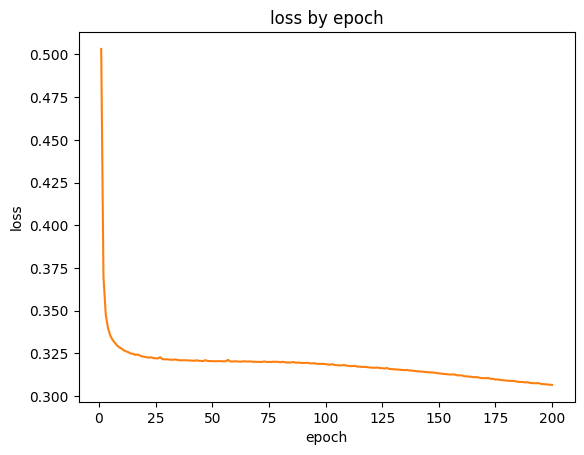

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(Iterations, losses_val, color='tab:orange')


plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss by epoch')
plt.show()

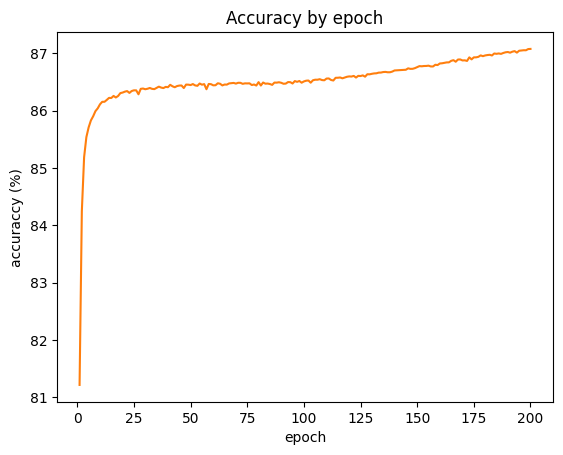

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(Iterations, acc_val, color='tab:orange')


plt.xlabel('epoch')
plt.ylabel('accuraccy (%)')
plt.title('Accuracy by epoch')
plt.show()

In [16]:
model.load_state_dict(best_weights)

correct_test = 0
total_test = 0
outputs_test = torch.squeeze(model(X_gpu_test))
loss_test = criterion(outputs_test, y_gpu_test)

total_test += y_gpu_test.size(0)
correct_test += torch.eq(outputs_test.round(), y_gpu_test).sum()
accuracy_test = 100 * correct_test/total_test

In [17]:
accuracy_test.item()

86.98274993896484

In [18]:
# model_path = '../model/torch_softmax_sgd_384'
# torch.save(model.state_dict(), model_path)

In [19]:
from torcheval.metrics import BinaryAUROC

In [20]:
metric = BinaryAUROC()
metric.update(outputs_test, y_gpu_test)

In [21]:
metric.compute().item()

0.9414337810125